## Imports

In [1]:
import pandas as pd
import numpy as np
import math
from scipy import stats

In [2]:
from collections import defaultdict

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [4]:
# Add path to book code
import os
import sys

sys.path.append( os.path.join( '.', 'original', 'code') )

In [5]:
from original.code import nsfg, analytic, brfss

## Data Source

In [6]:
df_orig = nsfg.ReadFemPreg('original/code/2002FemPreg.dct', 'original/code/2002FemPreg.dat.gz')
print(f'Shape : {df_orig.shape}')
df_orig.head()

Shape : (13593, 244)


,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,NaN,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,NaN,6.1875


In [7]:
# Focus on relevant columns
relevant_cols = ['caseid', 'prglngth', 'outcome', 'pregordr', 'birthord', 'birthwgt_lb', 'birthwgt_oz', 'agepreg', 'finalwgt']
preg = df_orig.loc[:, relevant_cols]  # Not using loc here will lead to SettingWithCopyWarning
                                    # since pandas will not be able to ascertain if df is a view or a copy
# Calculate Total Weight
preg['totalwgt_lb'] = preg.birthwgt_lb + preg.birthwgt_oz / 16.0
print(f'Shape: {preg.shape}')

Shape: (13593, 10)


In [8]:
# Respondents Data
resp = nsfg.ReadFemResp('original/code/2002FemResp.dct', 
                        'original/code/2002FemResp.dat.gz')

In [9]:
# Areas of focus
live = preg.loc[preg.outcome == 1]
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

In [10]:
baby_boom = analytic.ReadBabyBoom('original/code/babyboom.dat')

In [11]:
behave_risk = brfss.ReadBrfss(filename='original/code/CDBRFS08.ASC.gz')

## Modeling Distributions

### Terms
* Empirical Distributions
* Analytic Distribution
* Complementary CDF
* Normal Probability Plot

In [12]:
baby_boom.head()

,time,sex,weight_g,minutes
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


In [13]:
def create_cdf(ser):
    return ser.value_counts(normalize=True).sort_index().cumsum()

### Exponential Distribution

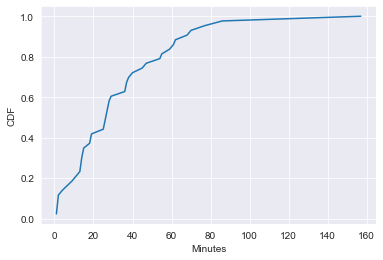

In [14]:
# Interarrival times of baby births
bb_diffs = baby_boom.minutes.diff()
bb_diffs_cdf = create_cdf(bb_diffs)
bb_diffs_cdf.plot(xlabel='Minutes', ylabel='CDF');

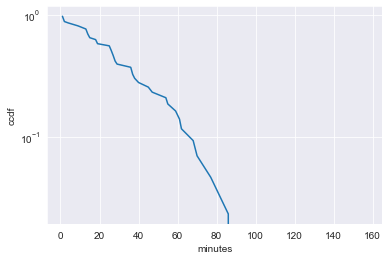

In [15]:
# Plot complementary CDF in log-y scale 
# Exponential distribution should give a straight line
(1-bb_diffs_cdf).plot(logy=True, ylabel='ccdf', xlabel='minutes');

### Normal Distribution

In [16]:
# Normal Distribution
stats.norm.cdf(0)

0.5

In [17]:
# Normal Probability Plot
def normal_prob_plot(samples):
    n = len(samples)
    normal_samples = np.random.normal(0, 1, n)
    return np.sort(normal_samples), np.sort(samples)

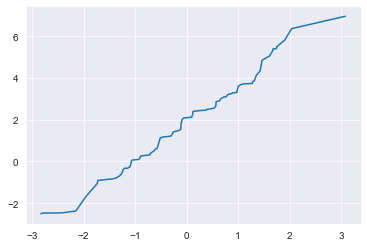

In [18]:
# Normal Probability Plot for Random Samples
samples = np.random.normal(2, 2, 100)
x, y = normal_prob_plot(samples)
plt.plot(x, y);

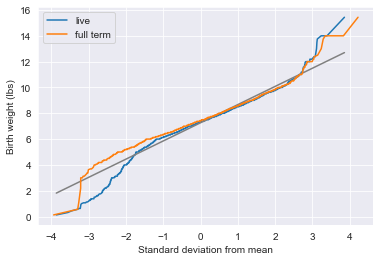

In [19]:
# Check if the normal distribution is a good fit for birth weights
live_weights = live.totalwgt_lb.dropna()
x, y = normal_prob_plot(live_weights)
plt.plot(x, y, label='live');
plt.ylabel('Birth weight (lbs)')
plt.xlabel('Standard deviation from mean')

intercept = live_weights.mean()
slope = live_weights.std()
plt.plot(x, slope * x + intercept, c='gray')

full_term_weights = live[live.prglngth >= 36].totalwgt_lb.dropna()
x, y = normal_prob_plot(full_term_weights)
plt.plot(x, y, label='full term')

plt.legend();

In [20]:
def create_normal_model(values):
    return stats.norm(values.mean(), values.std())

### Lognormal Distribution

* Logarith of values have a normal distribution

In [21]:
behave_risk.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
2,48.0,2,NaN,181.063210,NaN,165.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0


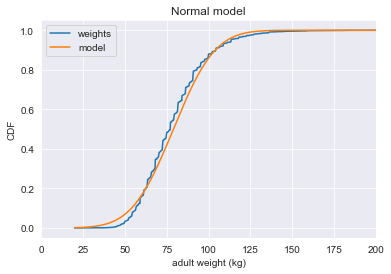

In [22]:
# CDF of weights
weights = behave_risk.wtkg2.dropna()
weights_cdf = create_cdf(weights)
weights_cdf.plot(xlabel='adult weight (kg)', ylabel='CDF', xlim=[0, 200], label='weights');

# CDF of normal model
normal_model = create_normal_model(weights)
norm_model_cdf = normal_model.cdf(x=weights_cdf.index)
plt.plot(weights_cdf.index, norm_model_cdf, label='model');
plt.legend();
plt.title('Normal model');

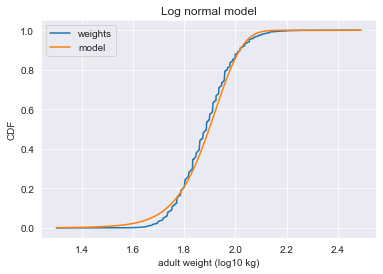

In [23]:
# CDF of log weights
log_weights = np.log10(behave_risk.wtkg2.dropna())
log_weights_cdf = create_cdf(log_weights)
log_weights_cdf.plot(xlabel='adult weight (log10 kg)', ylabel='CDF', label='weights');

# CDF of lognormal model
log_normal_model = create_normal_model(log_weights)
log_normal_model_cdf = log_normal_model.cdf(x=log_weights)
plt.plot(log_weights_cdf.index, norm_model_cdf, label='model');
plt.legend();
plt.title('Log normal model');

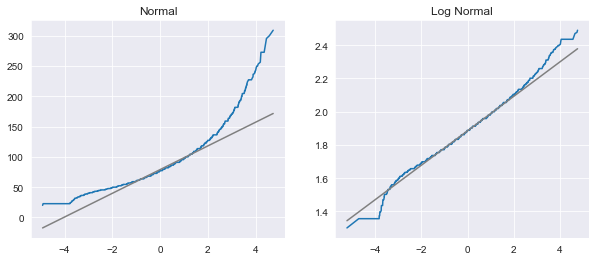

In [24]:
# Check which model better fits using normal probability plots
## Normal Model
fig, (ax_norm, ax_log) = plt.subplots(1, 2, figsize=(10, 4))
x, y = normal_prob_plot(weights)
ax_norm.plot(x, y)
ax_norm.set_title('Normal')

intercept = weights.mean()
slope = weights.std()
ax_norm.plot(x, slope * x + intercept, c='gray')

## Log Normal Model
x, y = normal_prob_plot(log_weights)
ax_log.plot(x, y);
ax_log.set_title('Log Normal')

intercept = log_weights.mean()
slope = log_weights.std()
ax_log.plot(x, slope * x + intercept, c='gray');